In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import scipy.io as sio
import cmaps
from matplotlib.colors import LinearSegmentedColormap
import datetime
import netCDF4 as nc4

In [2]:
goci_file = './GOCI_CHL/G2012002021640.L2_COMS_OC.nc'
goci_ds = nc4.Dataset(goci_file)
print('groups:')
print(goci_ds.groups.keys())
print('dimension:')
print(goci_ds.dimensions.keys())

groups:
dict_keys(['sensor_band_parameters', 'scan_line_attributes', 'geophysical_data', 'navigation_data', 'processing_control'])
dimension:
dict_keys(['number_of_lines', 'pixels_per_line', 'pixel_control_points', 'number_of_bands', 'number_of_reflective_bands'])


In [ ]:
print(goci_ds.dimensions['pixels_per_line'])

In [ ]:
print('sensor_band_parameters:')
print(goci_ds.groups['sensor_band_parameters'].variables.keys())
print('scan_line_attributes:')
print(goci_ds.groups['scan_line_attributes'].variables.keys())
print('geophysical_data:')
print(goci_ds.groups['geophysical_data'].variables.keys())
print('navigation_data:')
print(goci_ds.groups['navigation_data'].variables.keys())
print('processing_control:') 
print(goci_ds.groups['processing_control'].variables.keys())

In [3]:
reftime = datetime.datetime(2012,1,1)

In [8]:
np.unique(days)

masked_array(data=[2],
             mask=False,
       fill_value=999999,
            dtype=int32)

In [14]:
years = goci_ds.groups['scan_line_attributes'].variables['year'][:]
years = np.tile(years,(5567,1)).T
days = goci_ds.groups['scan_line_attributes'].variables['day'][:]-1
days = np.tile(days,(5567,1)).T
secs = goci_ds.groups['scan_line_attributes'].variables['msec'][:]*1e-3
secs = np.tile(secs,(5567,1)).T
lon = goci_ds.groups['navigation_data'].variables['longitude'][:]
lat = goci_ds.groups['navigation_data'].variables['latitude'][:]
chla = goci_ds.groups['geophysical_data'].variables['chlor_a'][:]

In [15]:
lon = np.ma.masked_outside(lon,112,138)
lat[lon.mask] = np.ma.masked
lat = np.ma.masked_outside(lat,21,42)
lon[lat.mask] = np.ma.masked
chla[lat.mask] = np.ma.masked



In [16]:
chla = np.ma.masked_outside(chla,0,30)
days_inecs = days[~chla.mask]
secs_inecs = secs[~chla.mask]
lon_inecs = lon[~chla.mask]
lat_inecs = lat[~chla.mask]
chla_inecs = chla[~chla.mask]

In [31]:
time_slice = np.unique(secs_inecs)
time_inrange = np.where(secs_inecs<=time_slice[-1])
time_inrange
time_stamp = reftime + \
             datetime.timedelta(days=np.nanmean(days_inecs[time_inrange])) + \
             datetime.timedelta(seconds=np.nanmean(secs_inecs[time_inrange]))

In [32]:
time_stamp

datetime.datetime(2012, 1, 2, 2, 31, 38, 529151)

In [33]:
lon_intime  = lon_inecs[time_inrange]
lat_intime = lat_inecs[time_inrange]
chla_intime =  chla_inecs[time_inrange]

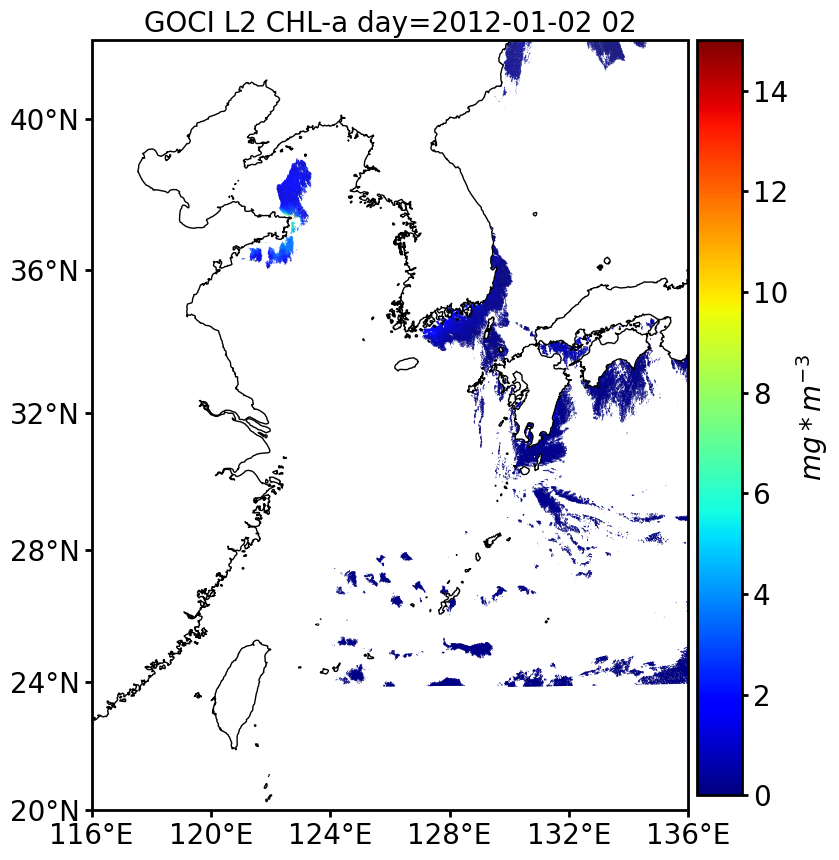

In [52]:
lon_intime  = lon_inecs[time_inrange]
lat_intime = lat_inecs[time_inrange]
chla_intime =  chla_inecs[time_inrange]

lon_bdy = [116,136];
lat_bdy = [20,42];
plt.rcParams['font.family'] = 'sans-serif'
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection = ccrs.Mercator())
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'k',zorder = 2,linewidth =1)
ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='w',zorder = -1)
ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+4,4),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1],4),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',
                                degree_symbol='°',
                                dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                    degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 20,top = 0, right = 0)
ax.set_title('GOCI L2 CHL-a day='+time_stamp.strftime('%Y-%m-%d %H'),fontsize=20)
cp =ax.scatter(lon_intime,lat_intime,0.05,chla_intime,vmin=0,vmax=15,
                     marker='.',linewidth=0.05,cmap='jet',transform = ccrs.PlateCarree(),)
position=fig.add_axes([0.82, 0.125,  0.045,0.755,])


cb = fig.colorbar(cp, cax = position, orientation='vertical')
for bnd in position.spines.keys():
        position.spines[bnd].set_linewidth('2')
position.tick_params(direction = 'out', length =4, width = 2, labelsize = 20)
# position.set_yticklabels(np.round(np.arange(0.2,1.4,0.2),1))
cb.set_label('$mg*m^{-3}$',fontsize = 20) 
plt.savefig('./GOCI_CHL/chla_%s.jpeg'%(time_stamp.strftime('%Y-%m-%d %HH')),bbox_inches='tight',dpi=1200)
plt.show()


In [ ]:
lon1d_intime